# Heat Transfer Simulation for Sofostik
## 1. User Information
## 2. Code

    Most of the code providing interactions with the CDB has been imported from the Sofistik documentation :
    https://docs.sofistik.com/2024/en/cdb_interfaces/python/examples/python_example1.html

    * 2.1 connecting to the CDB
    * 2.2 reading node properties

   

In [15]:
# +============================================================================+
# | Company:   SOFiSTiK AG                                                     |
# | Version:   SOFiSTIK 2024                                                   |
# +============================================================================+

import os               # for the environment variable necessary, this is a great tool
import platform         # checks the python platform
import string
from ctypes import *    # read the functions from the cdb

# This example has been tested with Python 3.7 (64-bit)
print ("The path variable=", os.environ["Path"])

# Check the python platform (32bit or 64bit)
print ("Python architecture=", platform.architecture())
sofPlatform = str(platform.architecture())

# Get the DLLs (32bit or 64bit DLL)
if sofPlatform.find("32Bit") < 0:
    # Set environment variable for the dll files
    print ("Hint: 64bit DLLs are used")

    # Set DLL dir path - new in PY 3.8 for ctypes
    # See: https://docs.python.org/3/whatsnew/3.8.html#ctypes
    os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024\interfaces\64bit")
    os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024")

    # Get the DLL functions
    myDLL = cdll.LoadLibrary("sof_cdb_w-2024.dll")
    py_sof_cdb_get = cdll.LoadLibrary("sof_cdb_w-2024.dll").sof_cdb_get
    py_sof_cdb_get.restype = c_int

    py_sof_cdb_kenq = cdll.LoadLibrary("sof_cdb_w-2024.dll").sof_cdb_kenq_ex
else:
    # Set environment variable for the DLL files
    print ("Hint: 32bit DLLs are used")

    # Set DLL dir path - new in PY 3.8 for ctypes
    # See: https://docs.python.org/3/whatsnew/3.8.html#ctypes
    os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024\interfaces\32bit")
    os.add_dll_directory(r"C:\Program Files\SOFiSTiK\2024\SOFiSTiK 2024")

    # Get the DLL functions
    myDLL = cdll.LoadLibrary("cdb_w31.dll")
    py_sof_cdb_get = cdll.LoadLibrary("cdb_w31.dll").sof_cdb_get
    py_sof_cdb_get.restype = c_int

    py_sof_cdb_kenq = cdll.LoadLibrary("cdb_w31.dll").sof_cdb_kenq_ex

# Connect to CDB
Index = c_int()
cdbIndex = 99

# input the cdb path here
fileName = r"C:\Users\Côme Delecourt\Desktop\TESTS\Sophistik\tunneltest.cdb"

# important: Unicode call!
Index.value = myDLL.sof_cdb_init(fileName.encode('utf8'), cdbIndex)

# get the CDB status
cdbStat = c_int()
cdbStat.value = myDLL.sof_cdb_status(Index.value)

# Print the Status of the CDB
print ("CDB Status:", cdbStat.value)

The path variable= c:\Anaconda3;C:\Anaconda3;C:\Anaconda3\Library\mingw-w64\bin;C:\Anaconda3\Library\usr\bin;C:\Anaconda3\Library\bin;C:\Anaconda3\Scripts;C:\Anaconda3\bin;C:\Anaconda3\condabin;C:\windows\system32;C:\windows;C:\windows\System32\Wbem;C:\windows\System32\WindowsPowerShell\v1.0;C:\windows\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\Git\cmd;C:\Users\Côme Delecourt\AppData\Local\Microsoft\WindowsApps;C:\Users\Côme Delecourt\AppData\Local\Programs\Microsoft VS Code\bin
Python architecture= ('64bit', 'WindowsPE')
Hint: 64bit DLLs are used
CDB Status: 3


## 2.2 reading the node properties

In [16]:
# import all types from sofistik_daten.py, original file can be found by following
# --> examples/python/sofistik_daten.py
from sofistik_daten import *


pos = c_int(0)
datalen = c_int(0)

a = c_int()
ie = c_int(0)
datalen.value = sizeof(CNODE_EDG)
RecLen = c_int(sizeof(cnode_edg))

"""
do while ie == 0, see cdbase.chm, Returnvalue.
   = 0 -> No error
   = 1 -> Item is longer than Data
   = 2 -> End of file reached
   = 3 -> Key does not exist
"""
"""while ie.value < 2:
   ie.value = py_sof_cdb_get(Index, 20, 0, byref(cnode), byref(RecLen), 1)
   print("{:10d}{:10d}{:10d}{:10d}{:10.2f}{:10.2f}{:10.2f}".format(
      cnode.m_nr,      # node-number
      cnode.m_inr,     # internal node-number
      cnode.m_kfix,    # degree of freedoms
      cnode.m_ncod,    # additional bit code
      cnode.m_xyz[0],  # x coordinates
      cnode.m_xyz[1],  # y coordinates
      cnode.m_xyz[2])  # z coordinates
   )

   # Always read the length of record before sof_cdb_get is called
   RecLen = c_int(sizeof(cnode))
"""



# List to store all rows of output values
all_output_values = []

# Loop to read data from the database using sof_cdb_get function
while ie.value < 2:
    # Read data from the database using sof_cdb_get function
    ie.value = py_sof_cdb_get(Index, 20, 1, byref(cnode_edg), byref(RecLen), 1)
    
    # Check if the return value indicates the end of the data
    if ie.value >= 2:
        break  # Exit loop if the end of the data is reached

    # Create a list to hold non-zero node values
    output_values = []
    
    # Add node IDs to the output list, stopping when a zero is encountered
    for node_id in cnode_edg.m_id:
        if node_id == 0:
            break  # Stop when a zero is encountered
        output_values.append(node_id)
    
    # Determine the maximum length of nodes encountered so far
    max_length = len(output_values)  # Assuming 10 as initial maximum column count for print format

    # Update output_values to fill with zeros up to max_length
    while len(output_values) < max_length:
        output_values.append(0)

    # Append the current row of output values to the main list
    all_output_values.append(output_values)
    
    # Update RecLen to the size of the structure before the next iteration
    RecLen = c_int(sizeof(cnode_edg))

# The result is a list of lists
# print(all_output_values)

chains_of_nodes = []

for chain in all_output_values :
   for i in range(1, len(chain)) :
         if abs(chain[i+1] - chain[i]) != 1 :
            chains_of_nodes.append(chain[0:i+2])
            break
   # print(chain)

print(chains_of_nodes)
print(len(chains_of_nodes))

# Initialize necessary variables
pos = c_int(0)
datalen = c_int(0)

a = c_int()
ie = c_int(0)
datalen.value = sizeof(cnode_edg)
RecLen = c_int(sizeof(cnode_edg))

# List to store all rows of output values
all_nodes = []
precision = 1 # select precision to the meter = 0, mm = 3, etc...

"""
do while ie == 0, see cdbase.chm, Returnvalue.
   = 0 -> No error
   = 1 -> Item is longer than Data
   = 2 -> End of file reached
   = 3 -> Key does not exist
"""
while ie.value < 2:
    ie.value = py_sof_cdb_get(Index, 20, 0, byref(cnode), byref(RecLen), 1)
    
    # Check if the return value indicates the end of the data
    if ie.value >= 2:
        break  # Exit loop if the end of the data is reached

    # Create a list to hold current node values
    node_values = [
        cnode.m_nr,      # node-number
        bin(cnode.m_kfix)[2:],    # degree of freedoms, binary string
        round(cnode.m_xyz[0], precision),  # x coordinate, trucated
        round(cnode.m_xyz[1], precision),  # y coordinate, truncated
    ]

    # Append the current node values to the main list
    all_nodes.append(node_values)

    # Always read the length of record before sof_cdb_get is called
    RecLen = c_int(sizeof(cnode))

# The result is a list of lists containing node information
# You can return it from a function or use it as needed
# Here we can simply print the result for demonstration
# print(all_nodes)

# We need to link the different chains of nodes to form the structure's geometric frames that separate interior from exterior
# We now group the data of each node in a list of lists that is in the same order as chain_of_nodes

def reconstruct_cycles(chains):
    remaining_chains = chains[:]  # Make a copy to avoid modifying the original list
    cycles = [remaining_chains.pop(0)]

    while len(remaining_chains) > 0:
        if cycles[-1][0] != cycles[-1][-1]:
            merged = False  # Flag to check if any merging happens
            pop_next = []

            for i in range(len(remaining_chains)):
                if remaining_chains[i][0] == cycles[-1][-1]:
                    cycles[-1].extend(remaining_chains[i][1:])
                    pop_next.append(i)
                    merged = True
                elif remaining_chains[i][-1] == cycles[-1][-1]:
                    cycles[-1].extend(remaining_chains[i][-2::-1])
                    pop_next.append(i)
                    merged = True

            if len(pop_next) > 0:
                for k in pop_next[::-1]:  # Pop in reverse order
                    remaining_chains.pop(k)
            if not merged:
                # If no merging happens, append a new cycle
                cycles.append(remaining_chains.pop(0))
        else:
            cycles.append(remaining_chains.pop(0))

    return cycles



loops_of_nodes = reconstruct_cycles(chains_of_nodes)
print(len(loops_of_nodes))
print(loops_of_nodes)


loops_complete_data = []

for loop in loops_of_nodes :
    loops_complete_data.append([])
    for node in loop :
        for node_data in all_nodes :
            if node_data[0] == node :
                loops_complete_data[-1].append(node_data)


print(loops_complete_data)


[[1001, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1002], [1002, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1003], [1003, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1004], [1004, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 12

* 2.3 Geometric sampling
## 2.3.1 bresenham and fill bitmap


[(7, 7), (8, 7), (8, 7), (9, 7), (9, 7), (10, 7), (12, 7), (13, 7), (14, 7), (15, 7), (16, 7), (17, 7), (19, 7), (21, 7), (22, 7), (24, 7), (26, 7), (28, 7), (29, 7), (31, 7), (33, 7), (34, 7), (35, 7), (37, 7), (38, 7), (39, 7), (40, 7), (41, 7), (42, 7), (44, 7), (45, 7), (46, 7), (47, 7), (49, 7), (50, 7), (52, 7), (53, 7), (54, 7), (56, 7), (57, 7), (58, 7), (60, 7), (61, 7), (62, 7), (64, 7), (65, 7), (66, 7), (68, 7), (69, 7), (70, 7), (71, 7), (71, 7), (72, 7), (73, 7), (73, 7), (73, 7), (73, 8), (73, 8), (73, 9), (73, 10), (73, 11), (73, 12), (73, 13), (73, 14), (73, 16), (73, 17), (73, 18), (73, 19), (73, 20), (73, 21), (73, 22), (73, 23), (73, 24), (73, 25), (73, 26), (73, 27), (73, 28), (73, 29), (73, 30), (73, 31), (73, 32), (73, 34), (73, 35), (73, 36), (73, 37), (73, 37), (73, 38), (73, 39), (73, 39), (73, 39), (72, 39), (72, 39), (71, 39), (70, 39), (69, 39), (68, 39), (67, 39), (65, 39), (64, 39), (62, 39), (60, 39), (58, 39), (57, 39), (55, 39), (53, 39), (51, 39), (49

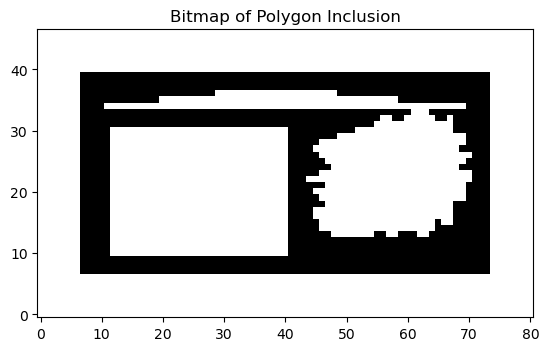

In [17]:
# Each loop needs to be converted into a closed curve in the plane. We will thence interpolate the curve with segments and define where matter stands
# We will then apply the scikit skeletonize (medial axis transform) tool to draw a medial path (a graph with leafs that will have to be pruned) that will be then sampled into beams

import numpy as np
from bresenham import bresenham
import matplotlib.pyplot as plt
from scipy.ndimage import binary_fill_holes
from skimage.util import invert

polygons = []
vertex_precision = 7

# Convert loops into polygons
for loop in loops_complete_data:
    poly = []
    for point in loop:
        poly.append(( int(point[2] * 10 ** precision) , int(point[3] * 10 ** precision) ))
    polygons.append(poly)

# Take the first polygon for this example
poly = polygons.pop(0)
"""
print(poly)
for i in polygons :
    print(i)
"""

# Get the bounds of the polygon to define the bitmap size
x_coords, y_coords = zip(*poly)
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

# Define the size of the bitmap without any buffer
width = int(max_x - min_x) + 2 * vertex_precision + 1 # Width of the bitmap
height = int(max_y - min_y) + 2 * vertex_precision + 1 # Height of the bitmap
 
# Calculate offsets to shift coordinates to the positive quadrant
offset_x = -min_x + vertex_precision
offset_y = -min_y + vertex_precision

# Shift polygon vertices to ensure all coordinates are positive for bitmap indexing
shifted_poly =[(x + offset_x , y + offset_y) for x, y in poly]
print(shifted_poly)

# Get points on the line using Bresenham's algorithm
contour = [shifted_poly[0]]
for i in range(len(shifted_poly)-1) :
    points = list(bresenham(shifted_poly[i][0],shifted_poly[i][1],shifted_poly[i+1][0],shifted_poly[i+1][1]))
    contour.extend(points[1:])

grid = np.zeros((width , height))
for i in contour :
    grid[i[0] , i[1]] = 1

# print(grid)
# Fill the inner space of the polygon with ones using binary_fill_holes
filled_grid = binary_fill_holes(grid.T).astype(int)    
# print(filled_grid)
# grid is now a 2D array where True represents a pixel inside the polygon and False represents outside
# np.set_printoptions(threshold=np.inf)
plt.imshow(filled_grid)

# now that the global frame has been defined, it is possible integrate its holes

if polygons != [] :
    int_grid = np.zeros((width , height))
    for polygon in polygons :
        shifted_polygon =[[x + offset_x , y + offset_y] for x, y in polygon]
        contours = [shifted_polygon[0]]
        for i in range(len(shifted_polygon)-1) :
            int_points = list(bresenham(shifted_polygon[i][0] , shifted_polygon[i][1] , shifted_polygon[i+1][0] , shifted_polygon[i+1][1]))
            contours.extend(int_points[1:])
        for i in contours :
            int_grid[i[0] , i[1]] = 1

    # Fill the inner space of the polygon with ones using binary_fill_holes
    filled_int_grid = binary_fill_holes(int_grid.T).astype(int)
    #print(filled_int_grid)

if polygons != [] :
    final_form = np.array(filled_grid + np.ones((height , width)) - filled_int_grid)

    
    

# For visualization purposes, let's plot the result
plt.imshow(final_form, cmap='binary' , origin = 'lower')
plt.title("Bitmap of Polygon Inclusion")
plt.show()

* 2.-1 Disconnecting from the database

In [18]:
# Close the CDB, 0 - will close all the files
myDLL.sof_cdb_close(0)

# Print again the status of the CDB, if status = 0 -> CDB Closed successfully
cdbStat.value = myDLL.sof_cdb_status(Index.value)
if cdbStat.value == 0:
    print ("CDB closed successfully, status = 0")

CDB closed successfully, status = 0


## 2.3.2 skeletonize

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


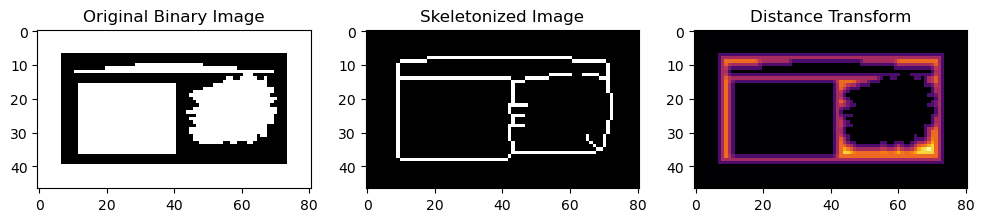

In [19]:
# skeletonize

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.util import invert
from scipy.ndimage import distance_transform_edt

# Example binary image (bitmap with ones and zeros)
binary_image = final_form

# Invert the image (if needed)
binary_image = invert(np.flipud(binary_image))

# Perform skeletonization
skeleton = skeletonize(binary_image)
distance = distance_transform_edt(binary_image)


# Invert the skeleton back
# skeleton = invert(skeleton)

print(skeleton)

# Visualize the original and skeletonized images
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(binary_image, cmap=plt.cm.gray)
ax[0].set_title('Original Binary Image')

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].set_title('Skeletonized Image')

ax[2].imshow(distance, cmap=plt.cm.inferno)
ax[2].set_title('Distance Transform')

plt.show()


## 2.3.3 leaf pruning

[[8, 18], [8, 19], [8, 20], [8, 21], [8, 22], [8, 23], [8, 24], [8, 25], [8, 26], [8, 27], [8, 28], [8, 29], [8, 30], [8, 31], [8, 32], [8, 33], [8, 34], [8, 35], [8, 36], [8, 37], [8, 38], [8, 39], [8, 40], [8, 41], [8, 42], [8, 43], [8, 44], [8, 45], [8, 46], [8, 47], [8, 48], [8, 49], [8, 50], [8, 51], [8, 52], [8, 53], [8, 54], [8, 55], [8, 56], [8, 57], [8, 58], [8, 59], [8, 60], [9, 10], [9, 11], [9, 12], [9, 13], [9, 14], [9, 15], [9, 16], [9, 17], [9, 61], [9, 62], [9, 63], [9, 64], [9, 65], [9, 66], [9, 67], [9, 68], [9, 69], [9, 70], [10, 9], [10, 71], [11, 9], [11, 71], [12, 9], [12, 71], [13, 9], [13, 54], [13, 55], [13, 56], [13, 57], [13, 58], [13, 59], [13, 60], [13, 64], [13, 65], [13, 66], [13, 67], [13, 68], [13, 71], [14, 9], [14, 10], [14, 11], [14, 12], [14, 13], [14, 14], [14, 15], [14, 16], [14, 17], [14, 18], [14, 19], [14, 20], [14, 21], [14, 22], [14, 23], [14, 24], [14, 25], [14, 26], [14, 27], [14, 28], [14, 29], [14, 30], [14, 31], [14, 32], [14, 33], [14, 

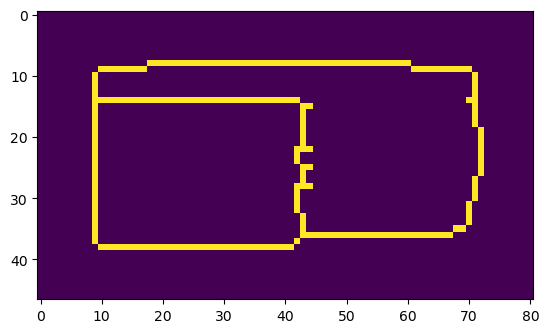

In [20]:
import numpy as np
import matplotlib.pyplot as plt

graph = skeleton.copy()
curve = [[i, j] for i, j in np.ndindex(graph.shape) if graph[i, j] == True]
print(curve)

m, n = np.shape(graph)
leafs = []

# Initial leaf detection
for (i , j) in curve :
    c = 0
    for k in range(-1, 2):
        for l in range(-1, 2):
            if graph[i + k][j + l] == True:
                c += 1
    if c < 3 and graph[i][j]:  # Adjust indices to match actual leaf position
        leafs.append([i, j])

# print("Initial leafs:", leafs)

# Leaf pruning loop
while len(leafs) > 0:
    new_leafs = []
    for k in leafs:
        graph[k[0], k[1]] = False
        new_l = []
        cc = 0
        for i in range(-1, 2):
            for j in range(-1, 2):
                ni, nj = k[0] + i, k[1] + j
                if 0 <= ni < m and 0 <= nj < n:  # Check within bounds
                    if graph[ni][nj] == True:
                        cc += 1
                        new_l.append([ni, nj])
        # Condition to ensure pruning doesn't cut through main structure
        # Check if the node is a true leaf by ensuring its removal doesn't disconnect the graph
        if cc == 1 and len(new_l) == 1:  # Prune only if there's exactly one neighbor
            new_leafs.extend(new_l)
        else:
            graph[k[0], k[1]] = True  # Revert change if not a true leaf

    leafs = new_leafs
    # print("New leafs:", leafs)

new_curve = [[i, j] for i, j in np.ndindex(graph.shape) if graph[i, j] == True]
print(len(curve))

plt.imshow(graph)

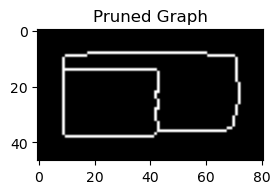

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the leaf patterns you want to prune
patterns = [
    np.array([
        [1, 1, 1],
        [0, 1, 0],
        [0, 0, 0]
    ]),
    np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 0]
    ]),
    np.flipud(np.array([
        [1, 1, 1],
        [0, 1, 0],
        [0, 0, 0]
    ])),
    np.flip(np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 0]
    ])),
    np.array([
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]),
    np.flipud(np.array([
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 0]
    ])),
    np.fliplr(np.array([
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 0]
    ])),
    np.fliplr(np.flipud(np.array([
        [1, 1, 0],
        [0, 1, 0],
        [0, 0, 0]
    ]))),
    np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 0]
    ]),
    np.flipud(np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 0]
    ])),
    np.fliplr(np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 0]
    ])),
    np.fliplr(np.flipud(np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 0]
    ])))
]

def prune_specific_leaves(graph):
    m, n = np.shape(graph)
    for i , j in new_curve : 
        if graph[i][j] :  # Check only if the center is True
            sub_matrix = graph[i-1:i+2, j-1:j+2]  # Get 3x3 sub-matrix around the point
            for pattern in patterns:
                if np.array_equal(sub_matrix, pattern):
                    graph[i][j] = False  # Prune the leaf
    return graph


# Apply the leaf pruning function
pruned_graph = prune_specific_leaves(graph.copy())
# Display the original and pruned graphs
"""plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(graph, cmap='gray')
plt.title('Original Graph')"""

plt.subplot(1, 2, 2)
plt.imshow(pruned_graph, cmap='gray')
plt.title('Pruned Graph')

plt.show()

## 2.3.4 node detection

Total number of detected nodes: 7
Detected edge nodes: [[13, 9], [14, 9], [14, 10], [15, 9], [35, 43], [36, 43], [36, 44]]
Vertices (cluster centers): [[14, 9], [36, 43]]
Adjacent Nodes associated with each cluster center:
Cluster Center (14, 9): [(12, 9), (14, 11), (16, 9)]
Cluster Center (36, 43): [(34, 43), (37, 42), (36, 45)]


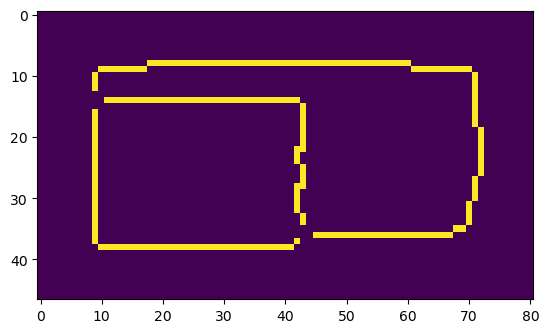

In [22]:
# Détecter les noeuds :

import numpy as np
import matplotlib.pyplot as plt

# Assuming pruned_graph, vertex_precision are defined correctly
m, n = np.shape(pruned_graph)
final_graph = pruned_graph.copy()

nodes = []
for i in range(vertex_precision, m - vertex_precision):
    for j in range(vertex_precision, n - vertex_precision):
        if pruned_graph[i][j] == True:
            c = 1
            f = [1]
            while c < vertex_precision + 1:
                h = 0
                for k in range(-c, c + 1):
                    for l in range(-c, c + 1):
                        if pruned_graph[i + k][j + l] == True:
                            h += 1
                c += 1
                f.append(h)
            g = [f[i + 1] - f[i] for i in range(vertex_precision - 1)]
            if all(x > 2 for x in g):
                nodes.append([i, j])

print(f"Total number of detected nodes: {len(nodes)}")
points = nodes.copy()

# Convert list of points to a set for efficient lookup
point_set = set(map(tuple, points))

# Debugging: Print detected points to verify correctness
print("Detected edge nodes:", points)

# Function to find clusters and select middle point of each cluster
def find_middle_points(points):
    point_set = set(map(tuple, points))
    visited = set()
    middle_points = []

    # Directions for 8-connectivity (including diagonals)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]

    def bfs(start):
        cluster = []
        queue = [start]
        visited.add(start)

        while queue:
            point = queue.pop(0)
            cluster.append(point)
            for direction in directions:
                neighbor = (point[0] + direction[0], point[1] + direction[1])
                if neighbor in point_set and neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(neighbor)

        return cluster

    # Find all clusters using BFS
    for point in points:
        if tuple(point) not in visited:
            cluster = bfs(tuple(point))
            if cluster:
                # Calculate the centroid of the cluster
                cluster_array = np.array(cluster)
                centroid = np.mean(cluster_array, axis=0)

                # Find the point in the cluster closest to the centroid
                distances = np.linalg.norm(cluster_array - centroid, axis=1)
                closest_point_index = np.argmin(distances)
                middle_point = cluster_array[closest_point_index].tolist()
                middle_points.append(middle_point)

    return middle_points

# Function to find adjacent nodes and associate them with cluster centers
def find_adjacent_nodes_with_centers(points, middle_points):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    adjacent_nodes_dict = {tuple(center): [] for center in middle_points}

    # Create a set of points for efficient lookup
    point_set = set(map(tuple, points))

    for point in points:
        point_tuple = tuple(point)
        # Find the closest cluster center to the current point
        closest_center = min(middle_points, key=lambda center: np.linalg.norm(np.array(center) - np.array(point)))

        for direction in directions:
            neighbor = (point_tuple[0] + direction[0], point_tuple[1] + direction[1])
            # Ensure neighbor is within bounds
            if 0 <= neighbor[0] < m and 0 <= neighbor[1] < n:
                if neighbor not in point_set and final_graph[neighbor] == True:
                    adjacent_nodes_dict[tuple(closest_center)].append(neighbor)
            else:
                # Debugging statement to catch out-of-bounds accesses
                print(f"Neighbor {neighbor} is out of bounds.")

    return adjacent_nodes_dict

# Find middle points of clusters
meta_vertices = find_middle_points(points)

# Find adjacent nodes associated with each cluster center
adjacent_nodes_with_centers = find_adjacent_nodes_with_centers(points, meta_vertices)

# Display results
print("Vertices (cluster centers):", meta_vertices)
print("Adjacent Nodes associated with each cluster center:")
for center, adj_nodes in adjacent_nodes_with_centers.items():
    print(f"Cluster Center {center}: {adj_nodes}")

# Visualize the graph with pruned edges
edge_graph = final_graph.copy()

# Ensure cluster_ext is defined or derived correctly, assuming cluster_ext contains nodes to be pruned
cluster_ext = []  # Adjust this based on your application logic

for node in cluster_ext:
    if 0 <= node[0] < m and 0 <= node[1] < n:
        edge_graph[node[0], node[1]] = False

# Check if points are within the graph's boundaries before modifying
for nod in points:
    if 0 <= nod[0] < m and 0 <= nod[1] < n:
        edge_graph[nod[0], nod[1]] = False
    else:
        print(f"Node {nod} is out of bounds for edge_graph.")

plt.imshow(edge_graph)
plt.show()

## 2.3.5 edge detection

In [23]:
import numpy as np

# Utility function to find neighbors of a point, including diagonals
def find_neighbors(point, bitmap):
    neighbors = []
    x, y = point
    height, width = bitmap.shape
    
    # Check all directions (up, down, left, right, and diagonals)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < height and 0 <= ny < width and bitmap[nx, ny] == 1:
            neighbors.append((nx, ny))
    
    return neighbors

# Trace a line starting from a given point
def trace_line(start_point, bitmap, visited):
    line = [start_point]
    visited.add(start_point)
    
    # Two ends of the line to expand from
    left_end = start_point
    right_end = start_point
    
    # Explore both ends until no more neighbors are found
    while True:
        new_point_added = False
        
        # Check neighbors of the left end
        left_neighbors = find_neighbors(left_end, bitmap)
        for neighbor in left_neighbors:
            if neighbor not in visited:
                line.insert(0, neighbor)
                visited.add(neighbor)
                left_end = neighbor
                new_point_added = True
                break
        
        # Check neighbors of the right end
        right_neighbors = find_neighbors(right_end, bitmap)
        for neighbor in right_neighbors:
            if neighbor not in visited:
                line.append(neighbor)
                visited.add(neighbor)
                right_end = neighbor
                new_point_added = True
                break
        
        # If no new point is added, the line is fully traced
        if not new_point_added:
            break
    
    return line

# Function to find all lines in the bitmap
def find_lines(bitmap):
    lines = []
    visited = set()
    height, width = bitmap.shape

    for x in range(height):
        for y in range(width):
            if bitmap[x, y] == 1 and (x, y) not in visited:
                line = trace_line((x, y), bitmap, visited)
                lines.append(line)
    
    return lines

lines = find_lines(edge_graph)

def augment_lines_with_meta_nodes(lines, adjacent_nodes_with_centers):
    augmented_lines = []
    
    for line in lines:
        start_extremity = line[0]
        end_extremity = line[-1]
        
        start_meta_node = None
        end_meta_node = None
        
        # Find the meta node for the start extremity
        for node, adjacent_points in adjacent_nodes_with_centers.items():
            if start_meta_node is None and any(
                abs(point[0] - start_extremity[0]) <= 1 and abs(point[1] - start_extremity[1]) <= 1
                for point in adjacent_points
            ):
                start_meta_node = node
        
        # Find the meta node for the end extremity
        for node, adjacent_points in adjacent_nodes_with_centers.items():
            if end_meta_node is None and any(
                abs(point[0] - end_extremity[0]) <= 1 and abs(point[1] - end_extremity[1]) <= 1
                for point in adjacent_points
            ):
                end_meta_node = node
        
        # Create the augmented line with meta nodes at both ends
        augmented_line = []
        if start_meta_node:
            augmented_line.append(start_meta_node)
        
        augmented_line.extend(line)
        
        if end_meta_node:
            augmented_line.append(end_meta_node)
        
        augmented_lines.append(augmented_line)
    
    return augmented_lines


augmented_lines = augment_lines_with_meta_nodes(lines, adjacent_nodes_with_centers)
for i in range(len(augmented_lines)) : 
    print(lines[i])
    # print(augmented_lines[i])
print(len(lines))


[(36, 45), (36, 46), (36, 47), (36, 48), (36, 49), (36, 50), (36, 51), (36, 52), (36, 53), (36, 54), (36, 55), (36, 56), (36, 57), (36, 58), (36, 59), (36, 60), (36, 61), (36, 62), (36, 63), (36, 64), (36, 65), (36, 66), (36, 67), (35, 68), (35, 69), (34, 70), (33, 70), (32, 70), (31, 70), (30, 71), (29, 71), (28, 71), (27, 71), (26, 72), (25, 72), (24, 72), (23, 72), (22, 72), (21, 72), (20, 72), (19, 72), (18, 71), (17, 71), (16, 71), (15, 71), (14, 71), (13, 71), (12, 71), (11, 71), (10, 71), (9, 70), (9, 69), (9, 68), (9, 67), (9, 66), (9, 65), (9, 64), (9, 63), (9, 62), (9, 61), (8, 60), (8, 59), (8, 58), (8, 57), (8, 56), (8, 55), (8, 54), (8, 53), (8, 52), (8, 51), (8, 50), (8, 49), (8, 48), (8, 47), (8, 46), (8, 45), (8, 44), (8, 43), (8, 42), (8, 41), (8, 40), (8, 39), (8, 38), (8, 37), (8, 36), (8, 35), (8, 34), (8, 33), (8, 32), (8, 31), (8, 30), (8, 29), (8, 28), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21), (8, 20), (8, 19), (8, 18), (9, 17), (9, 16), (9, 

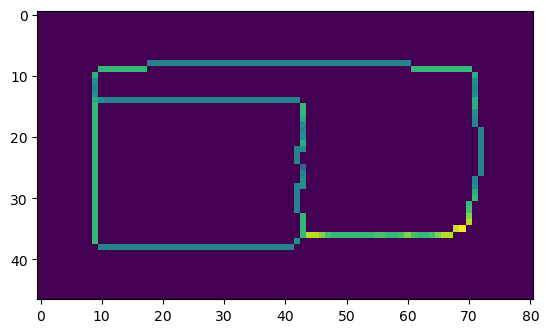

In [24]:
# déterminer l'épaisseur des poutres
m , n = np.shape(pruned_graph)
thickness = np.zeros((m , n))
for i in range(m) :
    for j in range(n) :
        if pruned_graph[i][j] :
            thickness[i][j] = distance[i][j] * 2 * 10 ** (- precision)
np.set_printoptions(threshold=np.inf)

plt.imshow(thickness)

## 2.3.6 sampling

In [25]:
# could sample according to curvature and thickness
import numpy as np
rate = 6

beams = []
for edge in augmented_lines :
    elements = []
    thicknesses =[]

    for i in range(len(edge)) :
        thicknesses.append(thickness[edge[i]])
        if i % rate == 0 :
            elements.append(((edge[i][0] - offset_x) * 10 ** (-precision),
                              (edge[i][1]-offset_y) * 10 ** (-precision)))
        if i == len(edge) and i % rate != 0 :
            elements.append(((edge[i][0] - offset_x) * 10 ** (-precision),
                              (edge[i][1]-offset_y) * 10 ** (-precision)))
    
    
    mean_thick = [ sum(thicknesses[j:j+rate+1]) / (rate + 1) for j in range(len(elements)-1) ]
    if len(elements) % rate != 0 :
        mean_thick.append(
        sum(thicknesses[rate * (len(elements) - 1):])/(len(thicknesses) - (rate * (len(elements) - 1))))
    struts = [ [elements[j],elements[j+1], np.linalg.norm((np.array(elements[j]) - np.array(elements[j+1]))**2), mean_thick[j] ] for j in range(len(elements)-1) ]
    beams.append(struts)

print(beams)


[[[(2.9000000000000004, 3.6), (2.9000000000000004, 4.3), 0.4899999999999996, 0.650509398160925], [(2.9000000000000004, 4.3), (2.9000000000000004, 4.9), 0.36000000000000065, 0.6505093981609249], [(2.9000000000000004, 4.9), (2.9000000000000004, 5.5), 0.3599999999999996, 0.6219379695894963], [(2.9000000000000004, 5.5), (2.8000000000000003, 6.1000000000000005), 0.3601388621073828, 0.6046365045762395], [(2.8000000000000003, 6.1000000000000005), (2.3000000000000003, 6.4), 0.26570660511172844, 0.6000000000000002], [(2.3000000000000003, 6.4), (1.7000000000000002, 6.5), 0.3601388621073822, 0.6046365045762395], [(1.7000000000000002, 6.5), (1.1, 6.4), 0.3601388621073822, 0.6092730091524788], [(1.1, 6.4), (0.5, 6.4), 0.3600000000000001, 0.6092730091524788], [(0.5, 6.4), (0.2, 6.0), 0.18357559750685845, 0.6092730091524788], [(0.2, 6.0), (0.2, 5.4), 0.3599999999999996, 0.6139095137287184], [(0.2, 5.4), (0.1, 4.800000000000001), 0.3601388621073817, 0.6312109787419752], [(0.1, 4.800000000000001), (0.1

# 3 Heat Equation

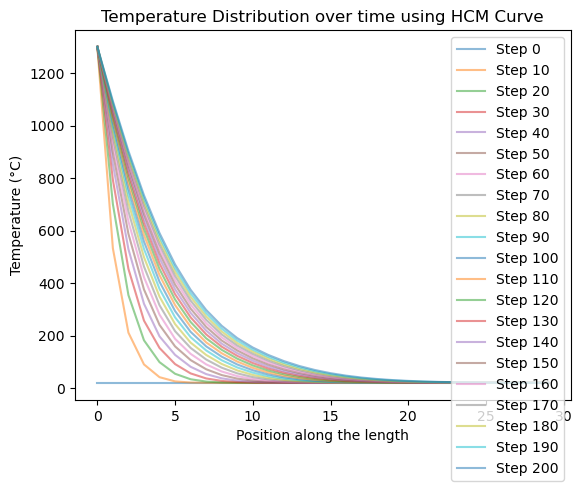

[1300.         1093.46850685  903.54315283  734.67482079  590.54625844
  471.14428251  374.50787033  297.65352097  237.26923559  190.44547112
  154.55665859  126.18307402  102.91102314   84.01768087   68.86445371
   56.8596496    47.46842801   40.21670366   34.69145044   30.53886149
   27.46104852   25.21161445   23.59037596   22.4375449    21.62769017
   21.06376709   20.67143261   20.39377758   20.18651951   20.        ]


In [26]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt

# Parameters
N = 30
m = 201
L = 0.5
t_max = 10800
dt = t_max / (m - 1)
dx = L / (N - 1)
D = 0.00001
r = (D * dt) / (2 * dx ** 2)
theta_0 = 20
rho_0 = 2500
humidity = 0

# Define functions
def conductivity(theta):
    if theta <= 140:
        return 2 - 0.2451 * (theta / 100) + 0.0107 * (theta / 100) ** 2  # W/mK
    if 140 < theta <= 160:
        return -0.02604 * theta + 5.324  # W/mK
    if theta > 160:
        return 1.36 - 0.136 * (theta / 100) + 0.0057 * (theta / 100) ** 2  # W/mK

def capacity(theta, humidity):  # humidity in %
    if theta <= 100:
        return 900  # (J/kg K)
    elif 100 < theta <= 115:
        return 900 + 360 * humidity
    elif 115 < theta <= 200:
        return 900 - (360 * humidity - 100) * theta / 85 + 100 + 200 * (360 * humidity - 100) / 85  # (J/kg K)
    elif 200 < theta <= 400:
        return 1000 + (theta - 200) / 2  # (J/kg K)
    elif 400 < theta:
        return 1100  # (J/kg K)

def rho(theta, rho_0):
    if 20 <= theta <= 115:
        return rho_0
    elif 115 < theta <= 200:
        return rho_0 * (1 - 0.02 * (theta - 115) / 85)
    elif 200 < theta <= 400:
        return rho_0 * (0.98 - 0.03 * (theta - 200) / 200)
    elif 400 < theta:
        return rho_0 * (0.95 - 0.07 * (theta - 400) / 800)

# Vectorize functions
rho = np.vectorize(rho)
capacity = np.vectorize(capacity)
conductivity = np.vectorize(conductivity)

# Fire curve functions
def HCM(t):
    return 20 + 1280 * (1 - 0.325 * np.exp(-0.167 * t) - 0.675 * np.exp(-2.5 * t))

def HC(t):
    return 20 + 1080 * (1 - 0.325 * np.exp(-0.167 * t) - 0.675 * np.exp(-2.5 * t))

def CN(t):
    return 20 + 345 * np.log10(8 * t + 1)

def FEU_EXT(t):
    return 20 + 660 * (1 - 0.687 * np.exp(-0.32 * t) - 0.313 * np.exp(-3.8 * t))

def EUREKA(t, theta_0=20):
    temperature = np.zeros_like(t)
    temperature[t <= 5] = ((1220 - theta_0) / 5) * t[t <= 5] + theta_0
    temperature[(t > 5) & (t <= 60)] = 1220
    temperature[(t > 60) & (t <= 170)] = 1885.45 - 1220 * t[(t > 60) & (t <= 170)] / 110
    temperature[t > 170] = 0
    return temperature

# Matrix A and B function
def mat_AB(u_t, dx, dt, N, humidity, rho_0):
    r = conductivity(u_t) * dt / (2 * rho(u_t, rho_0) * capacity(u_t, humidity) * dx ** 2)
    A = np.diag(np.ones(N) + 2 * r) + np.diag(-r[:-1], k=1) + np.diag(-r[1:], k=-1)
    B = np.diag(np.ones(N) - 2 * r) + np.diag(r[:-1], k=1) + np.diag(r[1:], k=-1)
    A[0, 0] = 1 + r[0]
    A[-1, -1] = 1 + r[-1]
    B[0, 0] = 1 - r[0]
    B[-1, -1] = 1 - r[-1]
    return A, B

# Function to solve next step
def solve_next_step(A, B, u_n):
    rhs = B @ u_n
    u_np1 = solve(A, rhs)
    return u_np1

# Main function to solve heat equation
def solve_HE(N, L, m, t_max, theta_0, humidity, rho_0, fire_type):
    # Map fire_type string to function
    fire_curves = {
        'HCM': HCM,
        'HC': HC,
        'CN': CN,
        'FEU_EXT': FEU_EXT,
        'EUREKA': lambda t: EUREKA(t, theta_0)
    }
    
    # Select the appropriate fire curve function
    if fire_type not in fire_curves:
        raise ValueError(f"Unknown fire type: {fire_type}")
    
    fire_curve = fire_curves[fire_type]
    
    dt = t_max / (m - 1)
    time_array = np.linspace(0, t_max, m)
    u_t = np.full(N, theta_0)
    boundary_cond = fire_curve(time_array)
    
    for i in range(m):
        A, B = mat_AB(u_t, dx, dt, N, humidity, rho_0)
        u_t = solve_next_step(A, B, u_t)
        u_t[0] = boundary_cond[i]
        u_t[-1] = theta_0
        if i % 10 == 0 :
            plt.plot(u_t, label=f"Step {i}", alpha=0.5)
    
    plt.legend()
    plt.xlabel('Position along the length')
    plt.ylabel('Temperature (°C)')
    plt.title(f"Temperature Distribution over time using {fire_type} Curve")
    plt.show()
    return u_t

# Example usage
curve = solve_HE(N, L, m, t_max, theta_0, humidity, rho_0, 'HCM')
print(curve)



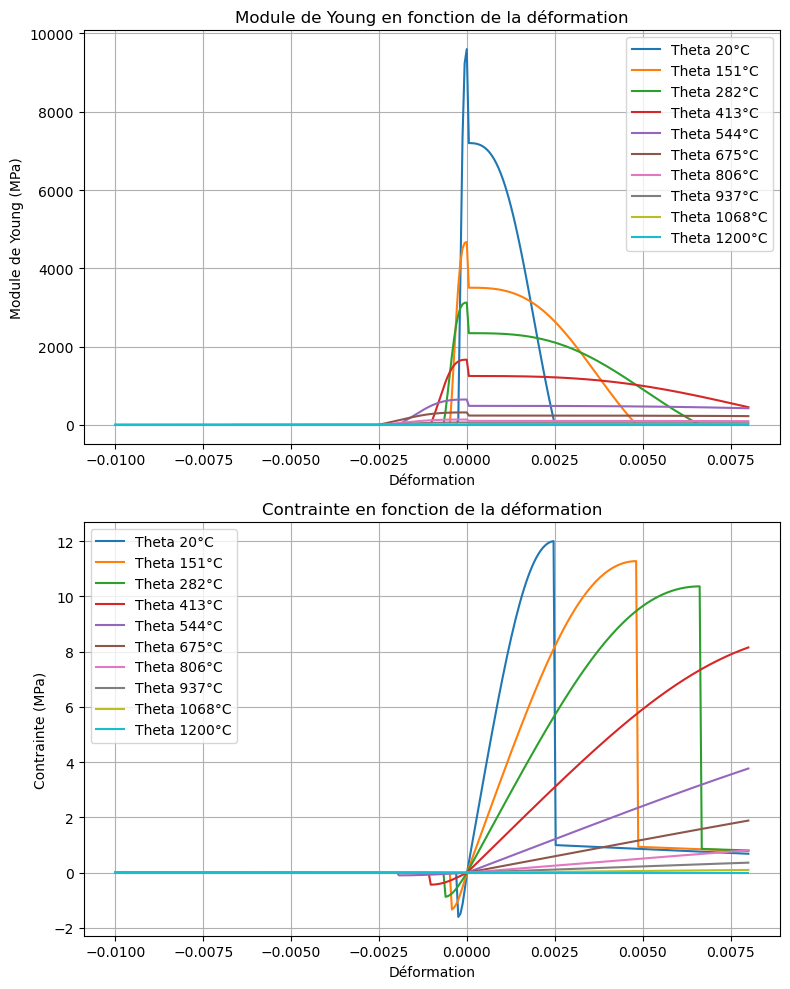

Mean E: 1236.774824243353
Max E: 7200.0


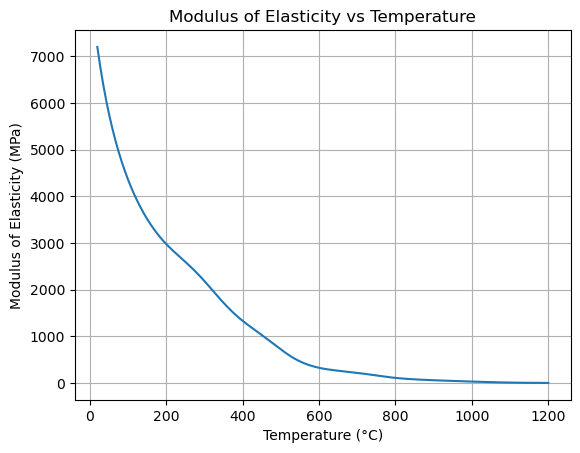

In [35]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

interpolation = 'cubic'
grain = 'calcaire'
f_ck = np.array([12, 16, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90])  # en MPa
f_ctm = np.array([1.6, 1.9, 2.1, 2.2, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.6, 4.8, 5.0])
fck = 12
def fctm(fck):    
    for i in range(len(f_ck)):
        if f_ck[i] == fck :
            fct = f_ctm[i]
    return fct

k_ct = fctm(fck) / fck

# Define the granulat dictionary based on the grain type
if grain == 'silicieux':
    granulat = {
        20: [1.00, 0.0025, 0.0200],
        100: [1.00, 0.0040, 0.0225],
        200: [0.95, 0.0055, 0.0250],
        300: [0.85, 0.0070, 0.0275],
        400: [0.75, 0.0100, 0.0300],
        500: [0.60, 0.0150, 0.0325],
        600: [0.45, 0.0250, 0.0350],
        700: [0.30, 0.0250, 0.0375],
        800: [0.15, 0.0250, 0.0400],
        900: [0.08, 0.0250, 0.0425],
        1000: [0.04, 0.0250, 0.0450],
        1100: [0.01, 0.0250, 0.0475],
        1200: [0.00, 0.0250, 0.0500],
        1300: [0.00, 0.0250, 0.0525]
    }
else:
    granulat = {
        20: [1.00, 0.0025, 0.0200],
        100: [0.97, 0.0040, 0.0225],
        200: [0.91, 0.0055, 0.0250],
        300: [0.85, 0.0070, 0.0275],
        400: [0.74, 0.0100, 0.0300],
        500: [0.60, 0.0150, 0.0325],
        600: [0.45, 0.0250, 0.0350],
        700: [0.30, 0.0250, 0.0375],
        800: [0.15, 0.0250, 0.0400],
        900: [0.08, 0.0250, 0.0425],
        1000: [0.04, 0.0250, 0.0450],
        1100: [0.01, 0.0250, 0.0475],
        1200: [0.00, 0.0250, 0.0500],
        1300: [0.00, 0.0250, 0.0525]
    }

def kc_t(theta):
    if (theta >= 20) and (theta <= 100):
        return 1.0
    elif (theta > 100) and (theta <= 600):
        return 1.0 - (theta - 100) / 500
    else:
        return 0

def calcul_epsilon(temperatures, granulat):
    temperatures = np.asarray(temperatures)

    if granulat == 'silicieux':
        epsilons = np.zeros_like(temperatures)
        mask_20_700 = (temperatures >= 20) & (temperatures <= 700)
        epsilons[mask_20_700] = -1.8e-4 + 9e-6 * temperatures[mask_20_700] + 2.3e-11 * temperatures[mask_20_700]**3
        mask_700_1300 = (temperatures > 700) & (temperatures <= 1300)
        epsilons[mask_700_1300] = 14e-3
    elif granulat == 'calcaire':
        epsilons = np.zeros_like(temperatures)
        mask_20_805 = (temperatures >= 20) & (temperatures <= 805)
        epsilons[mask_20_805] = -1.2e-4 + 6e-6 * temperatures[mask_20_805] + 1.4e-11 * temperatures[mask_20_805]**3
        mask_805_1300 = (temperatures > 805) & (temperatures <= 1300)
        epsilons[mask_805_1300] = 12e-3
    else:
        raise ValueError("Granulat inconnu. Choisissez 'silicieux' ou 'calcaire'.")

    if np.any((temperatures < 20) | (temperatures > 1300)):
        raise ValueError("Température hors de la plage valide (20°C - 1300°C).")

    return epsilons

points = np.array([temp for temp in granulat])

# Define interpolation functions
def fc_fck(granulat, points, interpolation):
    data = np.array([granulat[t][0] for t in points])
    fc_fck_interp = interp1d(points, data, kind=interpolation, fill_value="extrapolate")
    return fc_fck_interp

fc = fc_fck(granulat, points, interpolation)

def ec1_theta(granulat, points, interpolation):
    data = np.array([granulat[t][1] for t in points])
    ec1_theta_interp = interp1d(points, data, kind=interpolation, fill_value="extrapolate")
    return ec1_theta_interp

ec1 = ec1_theta(granulat, points, interpolation)

def ecu1_theta(granulat, points, interpolation):
    data = np.array([granulat[t][2] for t in points])
    ecu1_theta_interp = interp1d(points, data, kind=interpolation, fill_value="extrapolate")
    return ecu1_theta_interp

ecu1 = ecu1_theta(granulat, points, interpolation)

def contrainte_deformation(epsilon, fck, fc_fck_val, ec1_val, ecu1_val, theta):
    sigma = np.zeros_like(epsilon)
    mask1 = (0 <= epsilon) & (epsilon <= ec1_val)
    sigma[mask1] = (3 * fc_fck_val * fck / ec1_val) * epsilon[mask1] / (2 + ((epsilon[mask1] / ec1_val) ** 3))
    mask2 = (epsilon > ec1_val) & (epsilon <= ecu1_val)
    sigma[mask2] = - fc_fck_val * ((epsilon[mask2] - ecu1_val) / (ecu1_val - ec1_val))
    k = kc_t(theta)
    ec1t_val = 0.1 * ec1_val
    ecu1t_val = 0.1 * ecu1_val
    mask3 = (-ec1t_val <= epsilon) & (epsilon < 0)
    sigma[mask3] = -(3 * fc_fck_val * fck * k * k_ct / ec1t_val) * np.abs(epsilon[mask3]) / (2 + ((np.abs(epsilon[mask3]) / ec1t_val) ** 3))
    mask4 = (-ecu1t_val <= epsilon) & (epsilon < -ec1t_val)
    sigma[mask4] = fc_fck_val * k * k_ct * ((np.abs(epsilon[mask4]) - ecu1t_val) / (ecu1_val - ec1t_val))
    return sigma

def module_young(epsilons, theta, fck):
    f = fc(theta)
    ec = ec1(theta)
    epsilons = np.asarray(epsilons)
    epsi = np.abs(epsilons)
    # Compute E directly without internal masking
    mask1 = (epsilons >= 0) & (epsilons < ec)
    mask2 = (epsilons < 0) & (epsilons > -ec * 0.1)
    E = np.zeros_like(epsilons)
    E[mask1] = 6 * f * fck * (1 - (epsi[mask1] / ec) ** 3) / (ec * (2 + (epsi[mask1] / ec) ** 3) ** 2)
    E[mask2] = 6 * f * fck * k_ct * (1 - (epsi[mask2] / (ec * 0.1)) ** 3) / (ec * 0.1 * (2 + (epsi[mask2] / (ec * 0.1)) ** 3) ** 2)
    return E

# Example usage
thetas = np.linspace(20, 1200, 10).astype(int)
epsilons = np.linspace(-0.01, 0.008, 300)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot results for each temperature
for i in thetas:
    ec = ec1(i)
    ecu = ecu1(i)
    mask = (epsilons <= ec) & (epsilons >= -ec)
    epsi = epsilons[mask]
    # Calculate constraints
    contraintes = contrainte_deformation(epsilons, fck, fc(i), ec, ecu, i)
    # Plot constraints
    ax2.plot(epsilons, contraintes, label=f'Theta {i}°C')
    # Calculate Young's modulus
    E_values = module_young(epsi, i, fck)
    # Plot Young's modulus
    ax1.plot(epsi, E_values, label=f'Theta {i}°C')

# Add labels and legends
ax1.set_xlabel("Déformation")
ax1.set_ylabel("Module de Young (MPa)")
ax1.set_title("Module de Young en fonction de la déformation")
ax1.grid(True)
ax1.legend()

ax2.set_xlabel("Déformation")
ax2.set_ylabel("Contrainte (MPa)")
ax2.set_title("Contrainte en fonction de la déformation")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Compute E vs. temperature for a given epsilon
epsilon_value = 0.00  # Move this line before using it
thetas = np.linspace(20, 1200, 150)

def E_slices(u_t, epsilon_value):
    Es = []
    eps = np.array([epsilon_value])
    for i in u_t:
        E = module_young(eps, i, fck)[0]
        Es.append(E)
    return Es

Es = E_slices(thetas, epsilon_value)
print(f"Mean E: {np.mean(Es)}")
print(f"Max E: {Es[0]}")

plt.plot(thetas, Es)
plt.xlabel('Temperature (°C)')
plt.ylabel('Modulus of Elasticity (MPa)')
plt.title('Modulus of Elasticity vs Temperature')
plt.grid(True)
plt.show()

